In [1]:
"""Omid55"""

'Omid55'

# Imports

In [82]:
#Omid55
import requests
import pandas as pd
import pickle as pk
import csv
import time
import numpy as np
import random
from collections import defaultdict
import seaborn as sns
import matplotlib.pylab as plt
from scipy.sparse import csr_matrix
import networkx as nx
import glob
import networkx
import scipy
import classification_pipeline as pi
% matplotlib inline

# Useful Classes and Functions

In [3]:
def is_she_has_similar_history_in_stats_and_training(sid):
    # if there is at least 50% of training in the stats, we consider her as good
    r = len(list(set(summoners_training[sid].champions.keys()) - set(summoners_stats[sid].champions.keys()))) / float(len(summoners_training[sid].champions.keys()))
    return r < 0.5

In [4]:
"""Brief and useful info Match class"""
class Match:
    def __init__(self):
        self.summonerIds_championIds_isWinner_tier = []
        self.matchCreation = 0
        self.matchDuration = 0
        self.matchId = 0
        self.matchMode = ""
        self.matchType = ""
        
    def __init__(self, match):
        self.summonerIds_championIds_isWinner_tier = get_summonerIds_championIds_isWinner_tier(match)
        self.matchCreation = match['matchCreation']
        self.matchDuration = match['matchDuration']
        self.matchId = match['matchId']
        self.matchMode = match['matchMode']
        self.matchType = match['matchType']
        
    def __str__(self):
        return 'id:' + str(self.matchId) + ', mode:' + str(self.matchMode) + ', type:' + str(self.matchType) + ', creation:' + str(self.matchCreation) + ', duration:' + str(self.matchDuration) + ', my stats:' + str(self.summonerIds_championIds_isWinner_tier)
    

In [5]:
"""ChampionResult is a simple class with number of
    wins and loses as integer value"""
class ChampionResult:
    def __init__(self):
        self.wins = 0
        self.loses = 0
    
    def get_win_ratio(self):
        #assert self.wins + self.loses != 0, 'There is no matches available...'
        if not self.wins + self.loses:
            return 0
        return self.wins / float(self.wins + self.loses)
    
    def get_game_count(self):
        return self.wins + self.loses
        
        
"""SummonerChampionStats has a hashtable of champions which
    describes how many time summoner won or lost with that
    (GameResult as each item)"""
class SummonerChampionStats:
    def __init__(self):
        self.champions = defaultdict(lambda: ChampionResult())
    
    def get_game_count(self):
        return sum([c.get_game_count() for c in self.champions.values()])
    
    def get_win_ratio(self):
        w = sum([c.wins for c in self.champions.values()])
        l = sum([c.loses for c in self.champions.values()])
        #assert w + l != 0, 'There is no matches available...'
        if not w + l:
            return 0
        return w / float(w+l)
        
    def get_same_champion_game_count(self, champId):
        return self.champions[champId].get_game_count()
        
    def get_same_champion_win_ratio(self, champId):
        return self.champions[champId].get_win_ratio()
        

In [6]:
# preprocessing summoners from matches in order to have a dictionary of summoners with
#    a dictionary of their previous selected champions and GameResult for
#       for each selected champion (wins and loses)
def preprocess_given_matches(previous_matchIds_for_stats):
    summoners_stats = defaultdict(lambda: SummonerChampionStats())
    for mid in previous_matchIds_for_stats:
        summoner_champ_winner = matches[mid].summonerIds_championIds_isWinner_tier
        for s in summoner_champ_winner:
            if s[2]:
                summoners_stats[s[0]].champions[s[1]].wins += 1
            else:
                summoners_stats[s[0]].champions[s[1]].loses += 1
    return summoners_stats

Get the index for a sid in the network, it adds a new node if sid does not exist

In [7]:
def get_the_index_for_sid(sid):
    if sid not in sid_map:
        sid_map[sid] = len(sid_map)
    return sid_map[sid]

# in general format
def get_index_for(dictionary, val):
    if val not in dictionary:
        dictionary[val] = len(dictionary)
    return dictionary[val]

Get a list of network features for a given adjacency matrix

In [147]:
net_metric_names = ['AC', 'clustering', 'shortest_path_length', 'diameter', 'spectrum_v1', 'spectrum_v2', 'spectrum_v3', 'spectrum_v4', 'spectrum_v5']

def get_network_metrics(A):
    #nx.draw(A)
    return [nx.algebraic_connectivity(A), nx.average_clustering(A),
        nx.average_shortest_path_length(A) if nx.is_connected(A) else -1, 
            nx.diameter(A) if nx.is_connected(A) else -1] + list(nx.laplacian_spectrum(A))

Compute the weight between two nodes in the entire giant network 

In [73]:
def compute_weight_between_two_nodes_in_large_network(weighted_network, weighted_network_graph, n1, n2):
    assert type(weighted_network) == scipy.sparse.csr.csr_matrix, 'weighted_network is not a sparse matrix ...'
    assert type(weighted_network_graph) == networkx.classes.graph.Graph, 'weighted_network_graph is not a networkx graph ...'
    try:
        path = nx.shortest_path(weighted_network_graph, n1, n2)
    except:
        return 1000   # if there is not path and it has been raised nx.NetworkXNoPath then there is a large distance
    distance = 0
    for i in range(len(path)-1):
        distance += 1.0 / weighted_network[path[i], path[i+1]]
    return distance

In [ ]:
def my_maximum (A, B):
    BisBigger = A-B
    BisBigger.data = np.where(BisBigger.data < 0, 1, 0)
    return A - A.multiply(BisBigger) + B.multiply(BisBigger)

# Loading the whole data

In [9]:
# loading all saved matches
matches = {}
for fname in glob.glob("MATCHES_till_sid*.pkl"):
    print(fname)
    with open(fname, 'rb') as f:
        matches_chunk = pk.load(f)    
        matches = dict(matches.items()+matches_chunk.items())   # adding all matches together

MATCHES_till_sid512106.pkl
MATCHES_till_sid503154.pkl
MATCHES_till_sid35050.pkl
MATCHES_till_sid31287.pkl
MATCHES_till_sid4698.pkl
MATCHES_till_sid33108.pkl
MATCHES_till_sid515669.pkl
MATCHES_till_sid504948.pkl
MATCHES_till_sid5502.pkl
MATCHES_till_sid37119.pkl
MATCHES_till_sid1039.pkl
MATCHES_till_sid6755.pkl
MATCHES_till_sid10139.pkl
MATCHES_till_sid8499.pkl
MATCHES_till_sid3410.pkl
MATCHES_till_sid1900.pkl
MATCHES_till_sid509003.pkl
MATCHES_till_sid7780.pkl
MATCHES_till_sid28766.pkl
MATCHES_till_sid514117.pkl
MATCHES_till_sid603363.pkl


In [10]:
print 'Length of all matches is', len(matches)

Length of all matches is 208711


# Separating the data to 3 parts: Stats, Training and Test Dataset

In [11]:
# selecting a sample of matches
SAMPLE_IT = False
if SAMPLE_IT:
    SAMPLE_SIZE = 10000
    sampled_matches_ids = [matches.keys()[s] for s in sorted(random.sample(range(len(matches)), SAMPLE_SIZE))]
else:  # all the data
    sampled_matches_ids = matches.keys()

# sorting matches with respect to their match creation date
dates = np.zeros(len(sampled_matches_ids))
for i, mid in enumerate(sampled_matches_ids):
    dates[i] = matches[mid].matchCreation
sampled_matches_ids_sorted = [x for (y,x) in sorted(zip(dates, sampled_matches_ids))]
#all(dates[i]<=dates[i+1] for i in range(len(dates)-1))  # for checking if this is sorted or no

# spliting the data to 70% for stats and 20% for training and 10% for testing 
stats_len = int(0.6*len(sampled_matches_ids_sorted))
training_len = int(0.2*len(sampled_matches_ids_sorted))
matchIds_for_stats = sampled_matches_ids_sorted[:stats_len]
matchIds_for_training_dataset = sampled_matches_ids_sorted[stats_len:stats_len+training_len]
matchIds_for_test_dataset = sampled_matches_ids_sorted[stats_len+training_len:]
print 'Length of matchIds_for_stats is\t\t\t', len(matchIds_for_stats), \
    '\nLength of matchIds_for_training_dataset is\t', len(matchIds_for_training_dataset), \
    '\nLength of matchIds_for_test_dataset is\t\t', len(matchIds_for_test_dataset)

Length of matchIds_for_stats is			125226 
Length of matchIds_for_training_dataset is	41742 
Length of matchIds_for_test_dataset is		41743


# Building the network of games from stats data

In [68]:
# finding the number of unique summoners
all_sids_in_stats = []
for mid in matchIds_for_stats:
    sc = matches[mid].summonerIds_championIds_isWinner_tier
    all_sids_in_stats+=[s[0] for s in sc]
N = len(set(all_sids_in_stats))
del all_sids_in_stats
print('There are', N, 'unique summoners in the stats data.')

There are 573069 unique summoners in the stats data.


In [69]:
sid_map = {}
edges = defaultdict(lambda: 0)
for mid in matchIds_for_stats:
    sc = matches[mid].summonerIds_championIds_isWinner_tier
    for i in range(len(sc)):
        for j in range(i+1, len(sc)):
            if sc[i][2] == sc[j][2]:   # if they were in the same team
                key = str(get_the_index_for_sid(sc[i][0])) + ',' + str(get_the_index_for_sid(sc[j][0]))
                edges[key] += 1
row, col, val = [], [], []
for k, v in edges.items():
    coordination = k.split(',')
    row.append(int(coordination[0]))
    col.append(int(coordination[1]))
    val.append(v)
# since N is so large, we build a sparse matrix to save the entire network in it
W = csr_matrix((val, (row, col)), shape=(N,N), dtype=np.int8)
del edges, row, col, val

In [ ]:
W = my_maximum(W, np.transpose(W))
WG = nx.Graph(W)

In [ ]:
# # degree distribution of the network
# plt.hist(sum(W).toarray())
# plt.title('Degree distribution in the entire network');

Preprocessing the summoners in the stats data

In [223]:
summoners_stats = preprocess_given_matches(matchIds_for_stats)
summoners_training = preprocess_given_matches(matchIds_for_training_dataset)

FIGURE: Win/lost distributions (on stat.data) of several typical players on the set of champions (prefer ones with large number of champions)

In [238]:
c = 0
for sid in summoners_stats.keys():
    if len(summoners_stats[sid].champions) >= 10:
        c+=1
        print(sid)
        if c >= 10:
            break

5
108
133
136
152
155
160
184
198
201


In [357]:
def plot_win_loses_distribution(data_type, summoners, sid):
    dd = []
    for k, v in summoners_stats[sid].champions.items():
        dd.append([k, v.wins, 'Wins'])
        dd.append([k, v.loses, 'Loses'])
    dtt = pd.DataFrame(dd, columns=['Champion ID', 'Count', 'Result'])
    fig = sns.barplot(x="Champion ID", y="Count", hue="Result", data=dtt)
    fig.set_title('Win/Lose distribution for each champion in the ' + data_type + ' data');
    plt.ylabel('Distribution', fontsize=16)
    fig.savefig(str(sid)+'.png')
    

In [358]:
sns.set(rc={"figure.figsize": (8, 6)})

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

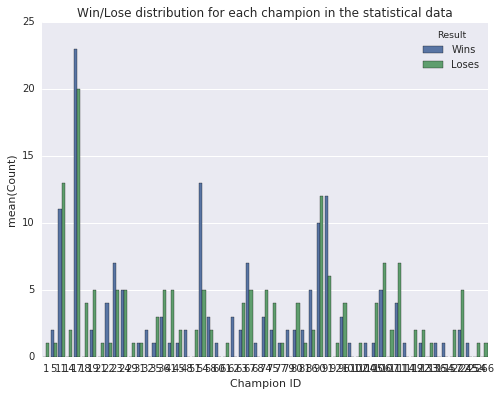

In [359]:
sid = 136
plot_win_loses_distribution('statistical', summoners_stats, sid)

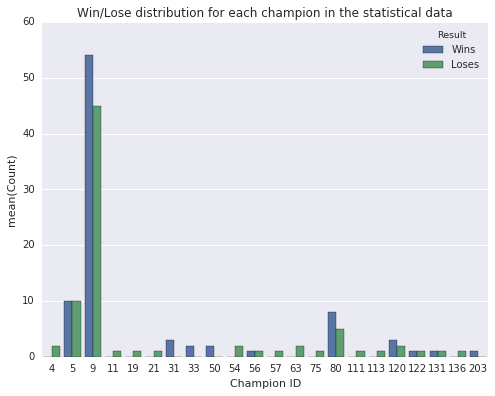

In [283]:
sid = 198
plot_win_loses_distribution('statistical', summoners_stats, sid)

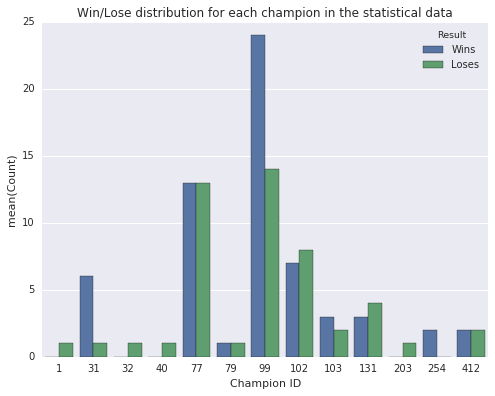

In [286]:
sid = 133
plot_win_loses_distribution('statistical', summoners_stats, sid)

See if people in training dataset and stats have similar champion choices (distribution)

In [13]:
good_sids = []
for sid in summoners_training.keys():
    if is_she_has_similar_history_in_stats_and_training(sid):
        good_sids.append(sid)

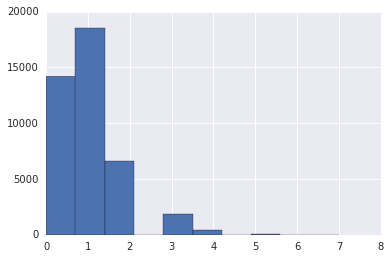

In [14]:
# Now we only consider those in the test set which are consisted of only good sids in their teams
cs = []
for mid in matchIds_for_test_dataset:
    sids = [m[0] for m in matches[mid].summonerIds_championIds_isWinner_tier]
    c = len(np.where(np.array([s in good_sids for s in sids]) == True)[0])
    cs.append(c)
plt.hist(cs);

# RUN FROM HERE

In [326]:
def make_the_dataset(dataset_fname, experience_features = True, network_features = True):
    THRESHOLD = 4
    selected_indices = np.where(np.array(cs)>=THRESHOLD)[0]
    matchIds_for_test_dataset_selected = [matchIds_for_test_dataset[i] for i in selected_indices]

    # building the dataset now:::
    # for each match in the dataset
    winner_edge_count = []
    loser_edge_count = []
    winner_weights = []
    loser_weights = []
    data = []
    for mid in matchIds_for_test_dataset_selected:
        summoners_not_found_winner = 0
        summoners_not_found_loser = 0
        winners = []
        losers = []

        sc = matches[mid].summonerIds_championIds_isWinner_tier
        # for team network 
        w_dict = {}
        l_dict = {}
        W_winner_team = np.zeros((5,5))
        W_loser_team = np.zeros((5,5))
        for i in range(len(sc)):
            for j in range(i+1, len(sc)):
                if sc[i][2] == sc[j][2]:
                    if sc[i][0] in sid_map and sc[j][0] in sid_map:
                        if sc[i][2]:
                            ii = get_index_for(w_dict,i)
                            jj = get_index_for(w_dict,j)
                            W_winner_team[ii,jj] = compute_weight_between_two_nodes_in_large_network\
                                (W, WG, get_the_index_for_sid(sc[i][0]), get_the_index_for_sid(sc[j][0]))
                            W_winner_team[jj,ii] = W_winner_team[ii,jj]
                        else:
                            ii = get_index_for(l_dict,i)
                            jj = get_index_for(l_dict,j)
                            W_loser_team[ii,jj] = compute_weight_between_two_nodes_in_large_network\
                                (W, WG, get_the_index_for_sid(sc[i][0]), get_the_index_for_sid(sc[j][0]))
                            W_loser_team[jj,ii] = W_loser_team[ii,jj]
        # thus we have winner weights, loser weights
        #   and their adjacency matrix as W_winner_team, W_loser_team
        wg = nx.Graph(W_winner_team)
        lg = nx.Graph(W_loser_team)
        winner_edge_count.append(np.count_nonzero(W_winner_team)/2)
        loser_edge_count.append(np.count_nonzero(W_loser_team)/2)
        winner_weights.append(sum(sum(W_winner_team)))
        loser_weights.append(sum(sum(W_loser_team)))
        
        # for each member in each team
        for s in sc:
            stat = summoners_stats[s[0]]
            tmp = [
                stat.get_game_count(),
                stat.get_win_ratio(),
                stat.get_same_champion_game_count(s[1]),
                stat.get_same_champion_win_ratio(s[1])
            ]
            if s[2]:
                winners.append(tmp)
            else:
                losers.append(tmp)

        sample = []
        if experience_features:
            if not winners:
                sample += [0, 0]
            else:
                sample += list(np.average(winners, axis=0)) + \
                    list(np.std(winners, axis=0))

        if network_features:
            sample += [np.average(sum(W_winner_team)),
                np.std(sum(W_winner_team))] + \
                get_network_metrics(wg)
        if experience_features:        
            if not losers:
                sample += [0, 0]
            else:
                sample += list(np.average(losers, axis=0)) + \
                list(np.std(losers, axis=0))
        if network_features:
            sample += [np.average(sum(W_loser_team)),
                    np.std(sum(W_loser_team))] + \
                    get_network_metrics(lg)
        data.append(sample)

    print('Data length is', len(data))

    # names for the features in the dataset
    names = ['avg_game_count', 'std_game_count', 'avg_win_ratio', 'std_win_ratio', 'avg_same_champion_game_count', 
                 'std_same_champion_game_count', 'avg_same_champion_win_ratio', 'std_same_champion_win_ratio', 
                             'average_weight', 'std_weight'] + net_metric_names
    feature_names = ['winner_' + na for na in names] + ['loser_' + na for na in names]
    
    dataset = pd.DataFrame(data=data)
    #dataset = pd.DataFrame(data=data, columns= feature_names)

    dataset.to_csv(dataset_fname)
    return winner_edge_count, loser_edge_count, winner_weights, loser_weights

In [ ]:
# THRESHOLD = 4
# selected_indices = np.where(np.array(cs)>=THRESHOLD)[0]
# matchIds_for_test_dataset_selected = [matchIds_for_test_dataset[i] for i in selected_indices]

# # building the dataset now:::
# # for each match in the dataset
# data = []
# for mid in matchIds_for_test_dataset_selected:
#     summoners_not_found_winner = 0
#     summoners_not_found_loser = 0
#     winners = []
#     losers = []
    
#     sc = matches[mid].summonerIds_championIds_isWinner_tier
#     # for each member in each team
#     for s in sc:
#         stat = summoners_stats[s[0]]
#         tmp = [
#             stat.get_game_count(),
#             stat.get_win_ratio(),
#             stat.get_same_champion_game_count(s[1]),
#             stat.get_same_champion_win_ratio(s[1])
#         ]
#         if s[2]:
#             winners.append(tmp)
#         else:
#             losers.append(tmp)
       
#     if not winners:
#         sample = [0, 0]
#     else:
#         sample = list(np.average(winners, axis=0)) + \
#             list(np.std(winners, axis=0))
#     if not losers:
#         sample += [0, 0]
#     else:
#         sample += list(np.average(losers, axis=0)) + \
#         list(np.std(losers, axis=0))
#     print(sample)
#     data.append(sample)

# print('Data length is', len(data))

# # names for the features in the dataset
# names = ['avg_game_count', 'avg_win_ratio', 'avg_same_champion_game_count', 'avg_same_champion_win_ratio', 
#                      'std_game_count', 'std_win_ratio', 'std_same_champion_game_count', 'std_same_champion_win_ratio', 
#                          'average_weight', 'std_weight'] + net_metric_names
# feature_names = ['winner_' + na for na in names] + ['loser_' + na for na in names]

# Classification with different models

In [327]:
dataset_fname = 'Classification2016_Dataset_STAT_TRAIN_TEST.csv'
wc,lc, ww, lw = make_the_dataset(dataset_fname, experience_features=True, network_features=False)

Data length is 577


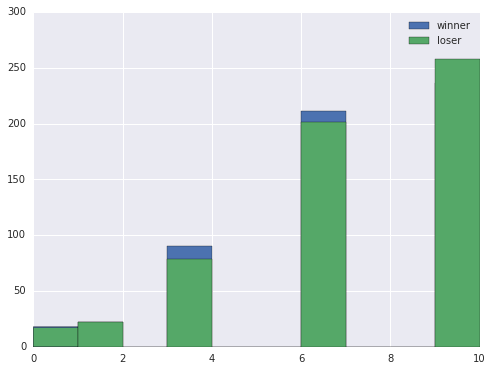

In [306]:
plt.hist(wc)
plt.hist(lc)
plt.legend(('winner', 'loser'))

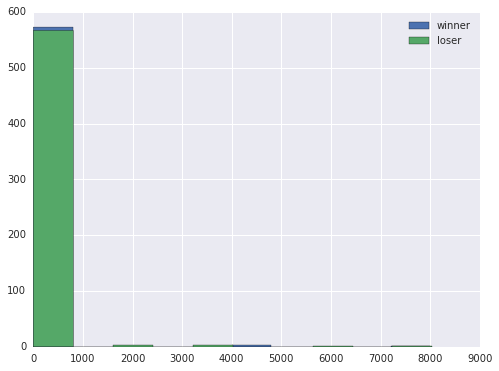

In [328]:
plt.hist(ww)
plt.hist(lw)
plt.legend(('winner', 'loser'))

In [161]:
dataset_fname = 'Classification2016_Dataset_STAT_TRAIN_TEST.csv'

Data length is 577
Starting ...
Loaded data size:  (577, 17)
Swapping  8.0 : 16.0  with 0 : 8.0  ...
Dataset size:  (577, 17)
                                classifier  test acc  train acc
0                                      KNN     53.95      63.88
1          Quadratic Discriminant Analysis     51.30      61.35
2                            Decision Tree     51.84      70.29
3             Linear Discriminant Analysis     54.07      58.81
4                      SVM with RBF kernel     54.94      69.98
5                              Naive Bayes     54.60      59.04
6                               Linear SVM     54.07      58.91
7                            Random Forest     50.11      99.65
8   Stochastic Gradient Descent Classifier     47.85      53.05
9                                 AdaBoost     55.15      74.74
10                     Logistic Regression     55.11      58.93
11                         Dummy (Uniform)     50.09      50.03
Computing embedding
Done.
average : 0.15s


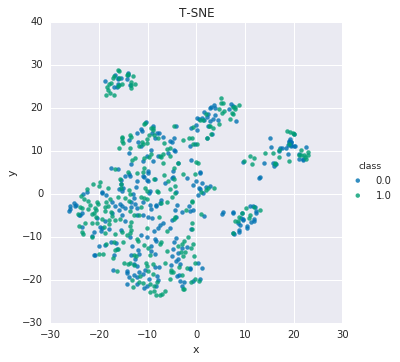

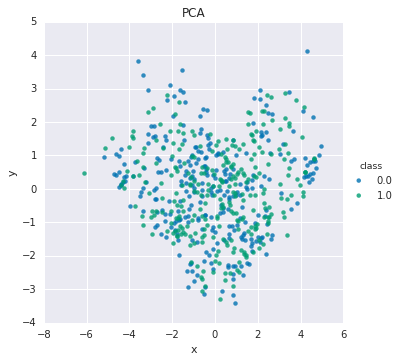

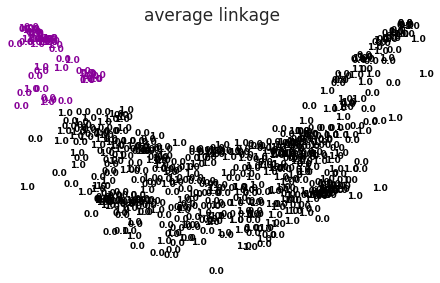

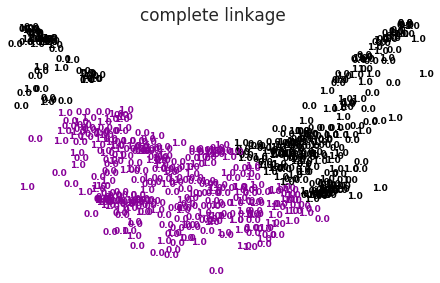

Computing embedding
Done.
average : 0.15s
complete : 0.15s


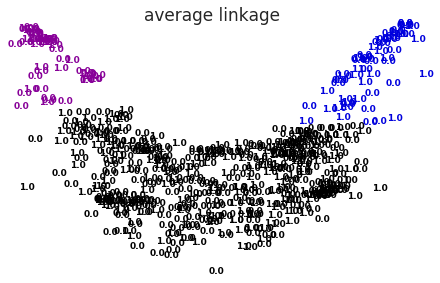

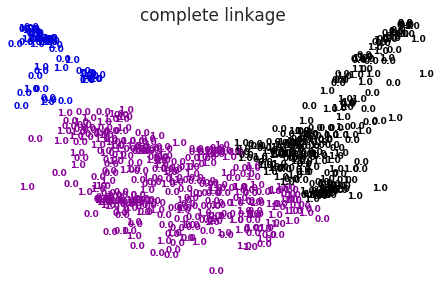

Computing embedding
Done.
average : 0.15s
complete : 0.15s


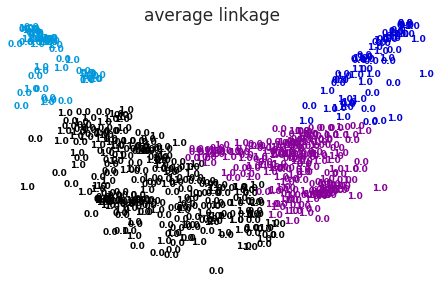

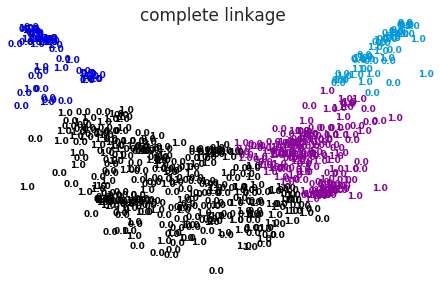

In [162]:
pi = reload(pi)
make_the_dataset(dataset_fname, experience_features=True, network_features=False)
pi.run_classifiers(dataset_fname)

# Linear SVM Tunning

In [324]:
pi = reload(pi)
dataset_fname = 'Classification2016_Dataset_STAT_TRAIN_TEST.csv'
pi.run_svm_with_tuning(dataset_fname, with_figure=False, verbose=False)

Starting ...
Loaded data size:  (577, 17)
Swapping  8.0 : 16.0  with 0 : 8.0  ...
Dataset size:  (577, 17)

Linear SVM Tunning:
0.1 58.058076225 60.9275974507
0.2 58.7477313975 60.8507855343
0.3 58.7477313975 60.7159848822
0.4 58.9201451906 60.7159848822
0.5 59.0925589837 60.7544834741
0.6 58.7447065941 60.8507855343
0.7 58.9201451906 60.8123610494
0.8 58.9171203872 60.8315177116
0.9 58.5692679976 60.8507855343
1 58.9171203872 60.908551949
3 59.2679975802 60.8315918186
5 58.7416817907 60.7354009189
10 58.0550514217 60.0617681933
20 57.3532970357 58.7140210464
50 47.4924379915 54.9978879502
80 54.7852389595 53.3215503187
100 54.2831215971 55.7670816659
150 51.9933454325 53.5148584556
200 51.9872958258 53.4570549874
1000 52.4954627949 52.8402993923
5000 53.8808227465 52.8015414258
10000 47.8221415608 51.9922558174
None


# Hierarchical Clustering and then Classification

In [394]:
dataset_fname = 'Classification2016_Dataset_STAT_TRAIN_TEST.csv'
pi = reload(pi)
pi.run_clustering_then_classification_with_tuning(dataset_fname, with_figure=False, linkage='complete', distance='cosine')

Starting ...
Loaded data size:  (577, 17)
Swapping  8.0 : 16.0  with 0 : 8.0  ...
Dataset size:  (577, 17)
Length of this cluster is: 234 

(234, 17)

Linear SVM Tunning:
0.1 56.7753623188 64.2909049876
0.2 57.2101449275 64.3863687655
0.3 57.2101449275 64.5292259084
0.4 57.2101449275 64.7664184157
0.5 56.7753623188 64.8616565109
0.6 56.7753623188 64.8138117806
0.7 56.7753623188 64.9090498759
0.8 56.7753623188 65.0040622884
0.9 56.7753623188 65.0983976529
1 56.7753623188 65.051004288
3 56.7753623188 64.8138117806
5 56.3224637681 64.9092755586
10 55.0724637681 63.8645903859
20 58.0797101449 62.487248928
50 48.3333333333 58.4039720153
80 54.1847826087 59.5436696005
100 50.4347826087 56.8381855112
150 50.8333333333 57.4019408711
200 55.0724637681 57.1710674791
1000 50.3804347826 53.5524712255
5000 50.8695652174 55.6501918303
10000 49.0760869565 52.9882645001

----------------------------------------------




Length of this cluster is: 67 

(67, 17)

Linear SVM Tunning:
0.1 60.2380952381 7

# NOW ALL WITH NETWORK FEATURES

In [314]:
dataset_withnet_fname = 'Classification2016_Dataset_STAT_TRAIN_TEST_WITH_NETWORK.csv'

Data length is 577
Starting ...
Loaded data size:  (577, 39)
Swapping  19.0 : 38.0  with 0 : 19.0  ...
Dataset size:  (577, 39)
                                classifier  test acc  train acc
0                                      KNN     51.97      65.09
1          Quadratic Discriminant Analysis     51.15      53.94
2                            Decision Tree     52.00      70.87
3             Linear Discriminant Analysis     51.64      60.41
4                      SVM with RBF kernel     55.98      66.94
5                              Naive Bayes     52.01      53.38
6                               Linear SVM     53.55      59.75
7                            Random Forest     51.15      99.83
8   Stochastic Gradient Descent Classifier     51.50      53.48
9                                 AdaBoost     51.49      76.74
10                     Logistic Regression     53.55      59.68
11                         Dummy (Uniform)     51.81      50.43
Computing embedding
Done.
average : 0.15

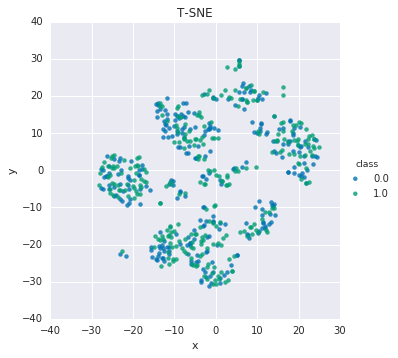

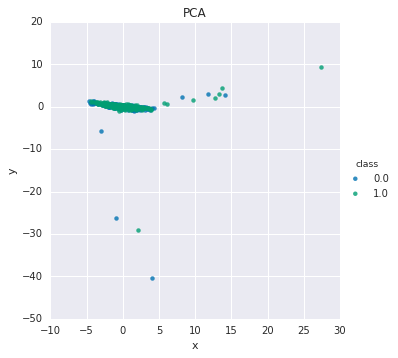

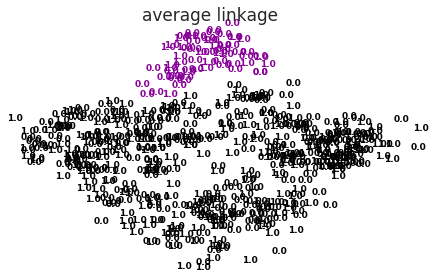

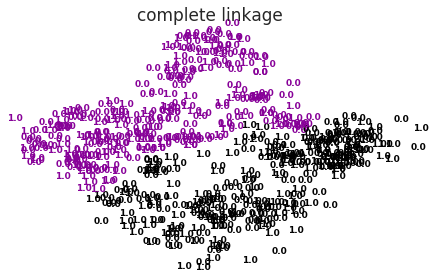

Computing embedding
Done.
average : 0.15s
complete : 0.14s


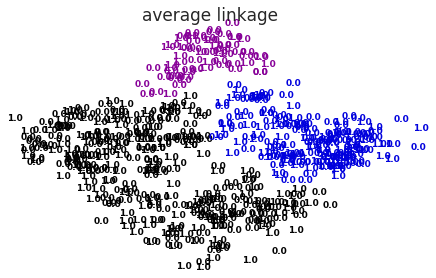

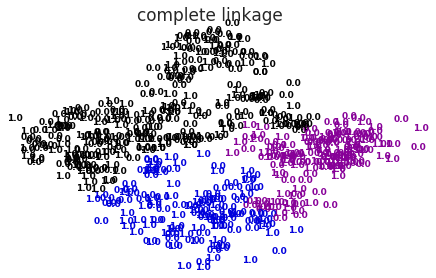

Computing embedding
Done.
average : 0.15s
complete : 0.14s


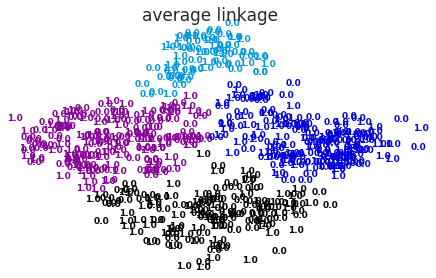

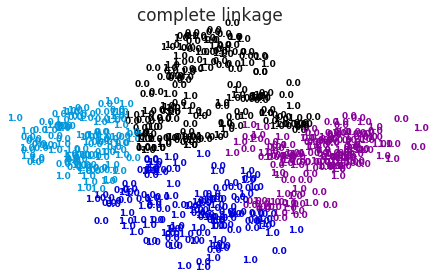

In [315]:
pi = reload(pi)
dt = make_the_dataset(dataset_withnet_fname, experience_features=True, network_features=True)
pi.run_classifiers(dataset_withnet_fname)

In [320]:
#pi = reload(pi)
pi.run_svm_with_tuning(dataset_withnet_fname, with_figure=False)

Starting ...
Loaded data size:  (577, 39)
Swapping  19.0 : 38.0  with 0 : 19.0  ...
Dataset size:  (577, 39)

Linear SVM Tunning:
0.1 55.1300665457 61.3328886913
0.2 55.1300665457 61.7179857715
0.3 54.9546279492 62.2765673633
0.4 55.1270417423 62.5269749518
0.5 55.647307925 62.8546390989
0.6 55.4779189353 62.7773825404
0.7 56.1675741077 63.201015266
0.8 55.3055051422 62.9506817845
0.9 55.3055051422 63.1239810286
1 55.9951603146 63.1432859048
3 55.8287961283 63.7017192826
5 55.4779189353 64.0095598044
10 53.7568058076 62.5081517712
20 50.4385964912 60.00359419
50 51.6696914701 57.4055506151
80 51.833030853 54.9202608567
100 49.594676346 55.8059878465
150 50.0786448881 53.2052023121
200 50.2389594676 55.1718541574
1000 54.609800363 53.9373054691
5000 51.1373260738 53.1092337335
10000 53.5480943739 54.86279087
None


# JUST NETWORKS

In [311]:
dataset_justnet_fname = 'Classification2016_Dataset_STAT_TRAIN_TEST_JUST_NETWORK.csv'

Data length is 577
Starting ...
Loaded data size:  (577, 23)
Swapping  11.0 : 22.0  with 0 : 11.0  ...
Dataset size:  (577, 23)
                                classifier  test acc  train acc
0                                      KNN     52.65      65.40
1          Quadratic Discriminant Analysis     49.41      51.82
2                            Decision Tree     47.99      67.99
3             Linear Discriminant Analysis     53.72      58.14
4                      SVM with RBF kernel     54.56      55.29
5                              Naive Bayes     48.85      50.14
6                               Linear SVM     53.54      56.33
7                            Random Forest     48.19      99.13
8   Stochastic Gradient Descent Classifier     49.39      51.61
9                                 AdaBoost     45.75      72.75
10                     Logistic Regression     53.53      55.29
11                         Dummy (Uniform)     54.04      49.62
Computing embedding
Done.
average : 0.14

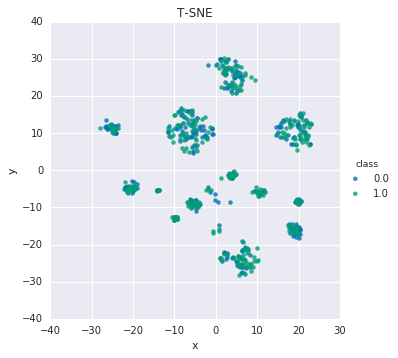

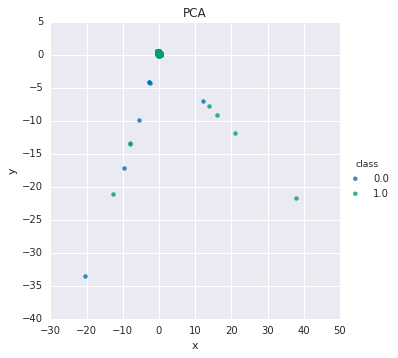

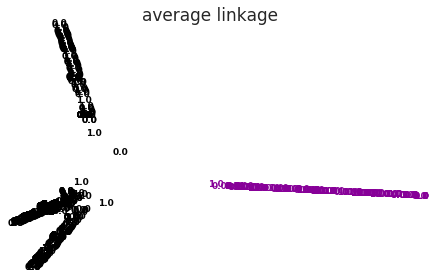

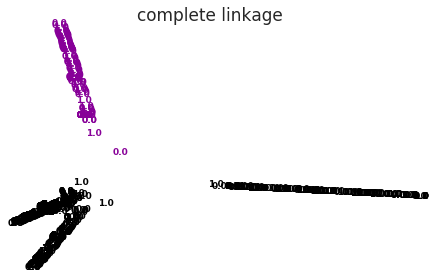

Computing embedding
Done.
average : 0.14s
complete : 0.14s


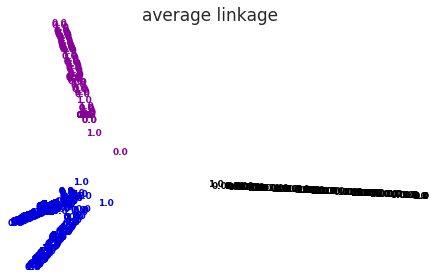

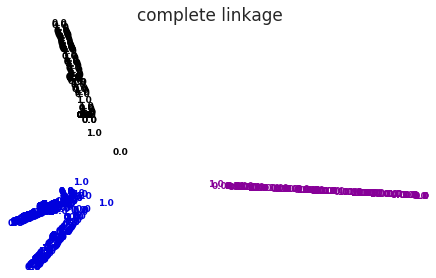

Computing embedding
Done.
average : 0.14s
complete : 0.14s


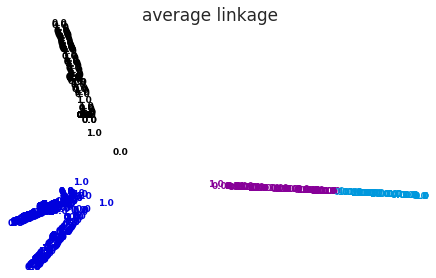

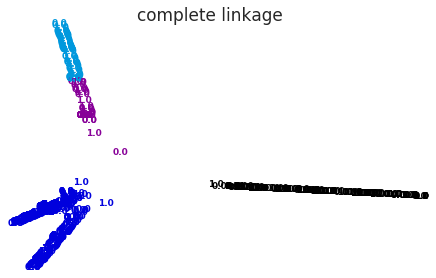

In [312]:
pi = reload(pi)
make_the_dataset(dataset_justnet_fname, experience_features=False, network_features=True)
pi.run_classifiers(dataset_justnet_fname)

In [360]:
pi.run_svm_with_tuning(dataset_justnet_fname, with_figure=False)

Starting ...
Loaded data size:  (577, 23)
Swapping  11.0 : 22.0  with 0 : 11.0  ...
Dataset size:  (577, 23)

Linear SVM Tunning:
0.1 51.8179068361 55.9986660738
0.2 51.1252268603 56.4029198162
0.3 51.6394434362 56.5379057359
0.4 52.1597096189 56.749703572
0.5 52.3381730188 56.8458574181
0.6 52.5075620085 57.2504075886
0.7 53.5480943739 56.8460797391
0.8 54.2407743497 57.365866311
0.9 55.2813067151 57.327441826
1 54.5886267393 57.8858381503
3 54.4192377495 58.5983029495
5 54.7640653358 58.3283681636
10 55.9739866909 58.5402771602
20 53.8868723533 58.1555876686
50 53.3817301875 53.3421891211
80 50.2510586812 53.8219579072
100 53.1972171809 52.4357492219
150 50.7592256503 52.7073884689
200 50.2661826981 52.5313472655
1000 49.9213551119 52.5705128205
5000 52.1627344223 50.915666222
10000 50.7622504537 51.3583444494
None
